## Authorship and Project Credit

This notebook is derived from a collaborative research project.

Contributing authors:

* Dominic Kosnica
* Sennai Kahssai 
* Dawinder Bansrow
* Michael Liu

All collaborators contributed to data processing, modeling, and analysis. This notebook represents a curated and extended version of the original group project for research portfolio purposes. 


# Classical Baseline Model for Electricity Grid Load Forecasting

## Abstract

Accurate electricity load forecasting is essential for power system planning, grid stability, and energy market operations. Modern forecasting pipelines increasingly incorporate advanced machine learning and hybrid computational models, including emerging quantum-enhanced approaches.

This notebook develops a classical machine learning baseline for short-term electricity grid load forecasting using high-resolution public data from the United Kingdom power system. Half-hourly electricity demand data spanning a full year is combined with external variables, including temperature and seasonal indicators, to construct a multivariate time-series forecasting model. The resulting classical pipeline establishes a rigorous benchmark for evaluating future hybrid quantum–classical forecasting systems.


## 1. Introduction and Motivation

Electricity demand forecasting is a core problem in energy systems engineering, directly influencing generation scheduling, grid reliability, and market efficiency. Load dynamics are shaped by complex temporal structure, weather variability, and seasonal behavior, making accurate prediction a challenging multivariate time-series modeling task.

In this study, we construct a classical machine learning baseline using real-world operational data from the UK electricity grid. Establishing a strong classical benchmark is essential before introducing hybrid quantum–classical forecasting models, ensuring that any claimed performance gains are evaluated against a rigorous industry-standard reference.


## 2. Dataset and Problem Formulation

The dataset consists of publicly available half-hourly electricity demand data from the England and Wales power system spanning a full calendar year. The prediction target is **ENGLAND_WALES_DEMAND**, representing system-wide electricity consumption at 30-minute resolution.

In addition to historical load, multiple exogenous variables are incorporated to reflect real-world operational forecasting conditions, including:

* Temperature
* Wind generation
* Solar generation
* Pumped storage activity
* Interconnector flows (NEMO, ElecLink)
* Scottish power transfer

A unified timestamp is constructed as:

$$
\text{datetime} = \text{Settlement Date} + (\text{Settlement Period} - 1) \times 30 \text{ minutes}
$$

Basic data cleaning includes removal of missing timestamps and forward-filling of exogenous variables. Calendar features are also added to capture periodic structure:

* Hour of day
* Day of week
* Month
* Weekend indicator

The task is formulated as a supervised multivariate time-series regression problem: given historical load and exogenous variables, the objective is to predict the next 30-minute electricity demand value.

This structure mirrors operational grid forecasting pipelines used in industry and system operators. 


## 3. Data Preprocessing and Feature Engineering

Temporal dependence is encoded using lagged demand features:

$$
\text{lag}*k = y*{t-k}, \quad k = 1, \dots, 48
$$

These capture short-term autocorrelation and daily cycles. Exogenous variables (temperature, wind, solar, interconnector flows) are also lagged to reflect delayed system responses.

After lag construction and removal of missing values, the final dataset contains:

* 48 demand lag features
* 7 exogenous lag features
* 4 calendar features

For a total of **59 predictive features**.

A chronological train–validation–test split is applied:

* 70% training
* 15% validation
* 15% testing

This prevents information leakage and accurately simulates real forecasting conditions. 


## 4. Classical Machine Learning Model

A Random Forest regression model is trained to learn nonlinear relationships between historical demand patterns, temperature, seasonal structure, and future electricity load. Ensemble tree-based methods are widely used in operational energy forecasting due to their ability to capture complex interactions without strong parametric assumptions.

The model serves as the classical performance baseline for subsequent comparison with hybrid quantum–classical forecasting architectures.


## 4. Classical Benchmark Models

To establish a rigorous classical baseline, three forecasting models are evaluated, representing increasing levels of model complexity.

### 4.1 Naive Persistence Baseline

The naive model assumes that electricity demand remains constant between consecutive 30-minute intervals:

[
\hat{y}*t = y*{t-1}
]

This provides the minimum acceptable performance level for any forecasting system and serves as a reference point for judging model skill.

---

### 4.2 Ridge Regression (Linear Baseline)

Ridge regression models electricity demand as a linear function of historical load, weather variables, and calendar features:

[
\hat{y}_t = \mathbf{w}^\top \mathbf{x}_t
]

with regularization to prevent overfitting. This model captures linear temporal structure and weather effects but cannot represent nonlinear interactions. It serves as a strong parametric baseline commonly used in operational forecasting.

---

### 4.3 Random Forest (Nonlinear Ensemble)

The Random Forest model is an ensemble of decision trees that captures complex nonlinear relationships between historical demand, weather variables, and temporal structure. By averaging multiple trees, it achieves strong generalization performance and robustness to noise.

Tree-based ensemble methods are widely used in industry-grade load forecasting systems due to their ability to model nonlinear feature interactions without heavy manual feature design.


## 5. Results and Evaluation

Three classical forecasting models are evaluated:

* Naive persistence baseline
* Ridge regression (linear model)
* Random Forest (nonlinear ensemble)

Model performance is measured using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), which are standard in power system forecasting due to their operational interpretability.

The Random Forest model achieves the strongest performance:

* Validation MAE ≈ 252 MW
* Test MAE ≈ 316 MW

Outperforming both the naive baseline and linear regression. This reflects the model’s ability to capture nonlinear interactions between historical load, weather variables, and calendar effects.

These results establish a high-quality classical benchmark that future hybrid quantum–classical forecasting models must exceed to demonstrate practical value. 


## 6. Conclusion and Extensions

This notebook presents a real-world classical machine learning baseline for electricity grid load forecasting using high-resolution UK demand data and external environmental variables. Strong classical benchmarks are essential for objectively assessing any proposed quantum or hybrid computational advantage.

Future work will extend this pipeline by integrating hybrid quantum–classical forecasting models and directly comparing their performance against this established classical reference.


## 7. Connection to Quantum and Hybrid Forecasting Models

This classical forecasting pipeline serves as the performance baseline for subsequent quantum and hybrid quantum–classical forecasting models developed in the companion Quantum repository.

In particular, this benchmark is used for direct comparison against:

* Quantum Reservoir Computing (QRC) models
* Continuous-Variable Kerr Quantum Reservoir Computing (CV-Kerr QRC) architectures

These quantum models are evaluated on the same electricity grid dataset and forecasting task, enabling controlled assessment of potential quantum advantages in time-series prediction.

Establishing a strong classical reference is essential for scientifically meaningful evaluation of quantum-enhanced forecasting systems.


Imports

In [36]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

Data Loading

In [37]:
file_path = "QUAC 605 Project Data.xlsx"  # change if needed

df = pd.read_excel(file_path, sheet_name=0)

# Drop useless 'Unnamed' columns (all-NaN or index artifacts)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())

# Drop rows where SETTLEMENT_DATE or SETTLEMENT_PERIOD is missing
df = df.dropna(subset=['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD']).copy()

# Convert SETTLEMENT_DATE to datetime
df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'])

df['SETTLEMENT_PERIOD'] = pd.to_numeric(
    df['SETTLEMENT_PERIOD'], errors='coerce'
).astype('Int64')

# If any periods are still NaN after coercion, drop them
df = df.dropna(subset=['SETTLEMENT_PERIOD']).copy()

print("After cleaning date/period:", df.shape)

Raw shape: (14448, 10)
Columns: ['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ENGLAND_WALES_DEMAND', 'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER', 'NEMO_FLOW', 'ELECLINK_FLOW', 'Temperature']
After cleaning date/period: (14448, 10)


Build Time Index & Calendar Features

In [38]:
# Each settlement period = 30 minutes. Period 1 -> 00:00
df['datetime'] = df['SETTLEMENT_DATE'] + pd.to_timedelta(
    (df['SETTLEMENT_PERIOD'] - 1).astype(int) * 30,  # cast to plain int *here* only
    unit='m'
)

# Sort by time for time-series consistency
df = df.sort_values('datetime').reset_index(drop=True)

# Calendar features
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek  # 0=Monday
df['month'] = df['datetime'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

print(df[['datetime', 'ENGLAND_WALES_DEMAND', 'SETTLEMENT_PERIOD', 'hour']].head())

             datetime  ENGLAND_WALES_DEMAND  SETTLEMENT_PERIOD  hour
0 2025-01-01 00:00:00                 19918                  1     0
1 2025-01-01 00:30:00                 20167                  2     0
2 2025-01-01 01:00:00                 20328                  3     1
3 2025-01-01 01:30:00                 19460                  4     1
4 2025-01-01 02:00:00                 18654                  5     2


Create Lag Features (Core of the Classical Time-Series Model)

In [39]:
target_col = 'ENGLAND_WALES_DEMAND'

# Exogenous variables (adjust if your columns differ)
exog_cols = [
    'Temperature',
    'EMBEDDED_WIND_GENERATION',
    'EMBEDDED_SOLAR_GENERATION',
    'PUMP_STORAGE_PUMPING',
    'SCOTTISH_TRANSFER',
    'NEMO_FLOW',
    'ELECLINK_FLOW'
]

# Fill NaNs in exogenous variables so they don't break lagging
df[exog_cols] = df[exog_cols].fillna(method='ffill').fillna(method='bfill')

# Use past 48 half-hour steps (one full day) of load as inputs
max_lag = 48

# A) Lags of the target
for lag in range(1, max_lag + 1):
    df[f'lag_{lag}'] = df[target_col].shift(lag)

# B) Lag-1 of exogenous variables
for col in exog_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

# C) Build final modeling dataset: drop all rows with any NaNs
df_model = df.dropna().reset_index(drop=True)

print("Shape after lagging & dropping NaNs:", df_model.shape)

Shape after lagging & dropping NaNs: (14400, 70)


/var/folders/kd/spn702l53c1d3pjzjd8bn49m0000gn/T/ipykernel_5086/973725670.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[exog_cols] = df[exog_cols].fillna(method='ffill').fillna(method='bfill')


Build Feature Matrix X and Target y

In [40]:
feature_cols = []

# 1) Add all load lags
feature_cols += [f'lag_{lag}' for lag in range(1, max_lag + 1)]

# 2) Add exogenous lags
feature_cols += [f'{col}_lag1' for col in exog_cols]

# 3) Add calendar features
feature_cols += ['hour', 'day_of_week', 'month', 'is_weekend']

X = df_model[feature_cols].values
y = df_model[target_col].values

print("Number of features:", X.shape[1])

# Time-based split: 70% train, 15% val, 15% test
n = len(df_model)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:],          y[val_end:]

time_train = df_model['datetime'].iloc[:train_end]
time_val   = df_model['datetime'].iloc[train_end:val_end]
time_test  = df_model['datetime'].iloc[val_end:]

print("Train size:", X_train.shape)
print("Val size:  ", X_val.shape)
print("Test size: ", X_test.shape)

Number of features: 59
Train size: (10080, 59)
Val size:   (2160, 59)
Test size:  (2160, 59)


Classical Models

4.1 Naive Baseline (Last Value)

In [41]:
# Because df_model already has lag_1 = y_{t-1}, we can just use that.
y_naive_test = df_model['lag_1'].values[val_end:]
y_test_naive_target = y[val_end:]

print("Naive shapes:", y_naive_test.shape, y_test_naive_target.shape)

mae_naive = mean_absolute_error(y_test_naive_target, y_naive_test)
rmse_naive = math.sqrt(mean_squared_error(y_test_naive_target, y_naive_test))
r2_naive = r2_score(y_test_naive_target, y_naive_test)

print(f"Naive baseline (lag_1) - MAE: {mae_naive:.2f}, RMSE: {rmse_naive:.2f}, R²: {r2_naive:.3f}")

Naive shapes: (2160,) (2160,)
Naive baseline (lag_1) - MAE: 639.57, RMSE: 830.64, R²: 0.960


Ridge Regression (Classical Linear Model)

In [42]:
ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])

ridge_model.fit(X_train, y_train)

y_val_pred_ridge = ridge_model.predict(X_val)
y_test_pred_ridge = ridge_model.predict(X_test)

# MAE / RMSE
mae_ridge_val = mean_absolute_error(y_val, y_val_pred_ridge)
rmse_ridge_val = math.sqrt(mean_squared_error(y_val, y_val_pred_ridge))

mae_ridge_test = mean_absolute_error(y_test, y_test_pred_ridge)
rmse_ridge_test = math.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

# R²
r2_ridge_val = r2_score(y_val, y_val_pred_ridge)
r2_ridge_test = r2_score(y_test, y_test_pred_ridge)

print(f"Ridge - VAL  MAE: {mae_ridge_val:.2f}, RMSE: {rmse_ridge_val:.2f}, R²: {r2_ridge_val:.3f}")
print(f"Ridge - TEST MAE: {mae_ridge_test:.2f}, RMSE: {rmse_ridge_test:.2f}, R²: {r2_ridge_test:.3f}")


Ridge - VAL  MAE: 265.80, RMSE: 346.88, R²: 0.988
Ridge - TEST MAE: 336.26, RMSE: 434.92, R²: 0.989


Random Forest (Nonlinear, Strong Classical Baseline)

In [43]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# MAE / RMSE
mae_rf_val = mean_absolute_error(y_val, y_val_pred_rf)
rmse_rf_val = math.sqrt(mean_squared_error(y_val, y_val_pred_rf))

mae_rf_test = mean_absolute_error(y_test, y_test_pred_rf)
rmse_rf_test = math.sqrt(mean_squared_error(y_test, y_test_pred_rf))

# R²
r2_rf_val = r2_score(y_val, y_val_pred_rf)
r2_rf_test = r2_score(y_test, y_test_pred_rf)

print(f"RandomForest - VAL  MAE: {mae_rf_val:.2f}, RMSE: {rmse_rf_val:.2f}, R²: {r2_rf_val:.3f}")
print(f"RandomForest - TEST MAE: {mae_rf_test:.2f}, RMSE: {rmse_rf_test:.2f}, R²: {r2_rf_test:.3f}")


RandomForest - VAL  MAE: 252.19, RMSE: 333.84, R²: 0.989
RandomForest - TEST MAE: 316.50, RMSE: 420.32, R²: 0.990


Visualize Predictions vs True Load

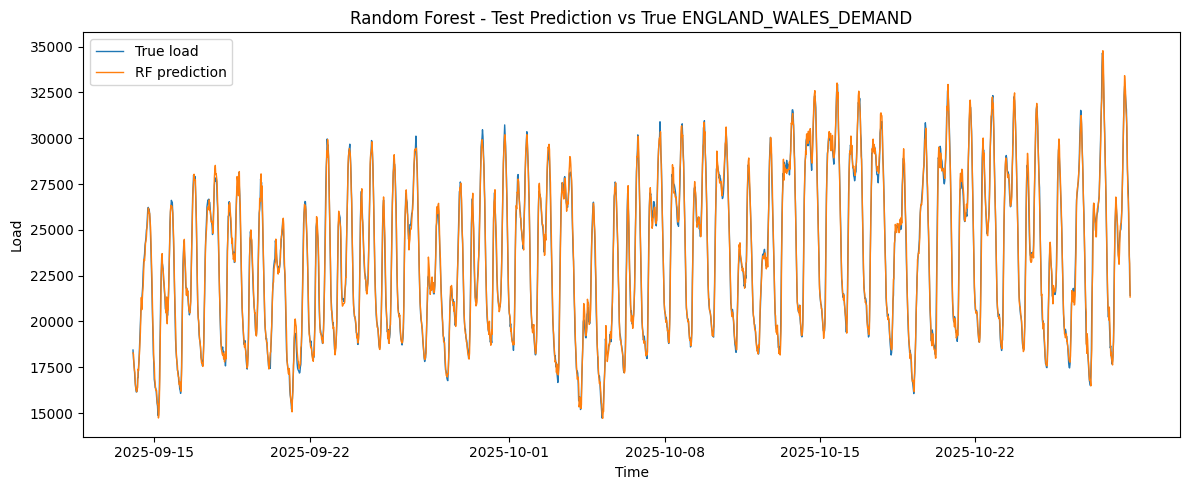

In [44]:
plt.figure(figsize=(12, 5))
plt.plot(time_test, y_test, label="True load", linewidth=1)
plt.plot(time_test, y_test_pred_rf, label="RF prediction", linewidth=1)
plt.title("Random Forest - Test Prediction vs True ENGLAND_WALES_DEMAND")
plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.tight_layout()
plt.show()
